In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import yaml
import math
from sklearn.preprocessing import OneHotEncoder

from makers.utils import *
from makers.model import build_model

In [20]:
DATA_PATH = "_input/data/book-COINBASE-BTC-USD.csv"
MODEL_NAME = '20220214_153356'

In [21]:
CONFIG_PATH = f'_output/models/{MODEL_NAME}/config.yml'
MODEL_PATH = f'_output/models/{MODEL_NAME}/model.h5'
SCALER_PATH = f'_output/models/{MODEL_NAME}/scaler1.h5'

In [25]:
config = yaml.safe_load(open(CONFIG_PATH, 'r'))
scaler1 = joblib.load(open(SCALER_PATH, 'rb'))
model = build_model(window_size=config['model']['window_size'], depth=config['model']['depth'])

In [33]:
df = pd.read_csv(DATA_PATH, index_col='timestamp', parse_dates=True).sort_index()
df = df[~df.index.duplicated(keep='first')]

In [35]:
# prediction horizon
td = f"{config['model']['prediction_horizon']}s"

# use timestamp diffs to calculate min_periods
ts = (df.index.to_series().diff()[1:].astype(int) / 1e9)
ts = ts[abs(ts) <= 100.]

# use min and max instead of mean
min_periods = math.ceil(config['model']['prediction_horizon'] / np.mean(ts) // 2)

df['p+'] = df['ap0'][::-1].rolling(td, min_periods=min_periods).max()[::-1] - df['ap0']
df['p-'] = df['bp0'] - df['bp0'][::-1].rolling(td, min_periods=min_periods).min()[::-1]
df['signal_true'] = (df['p+'] > config['model']['threshold']).astype(int) - (df['p-'] > config['model']['threshold']).astype(int)

# remove na
df = df[~df.isna().any(axis=1)]

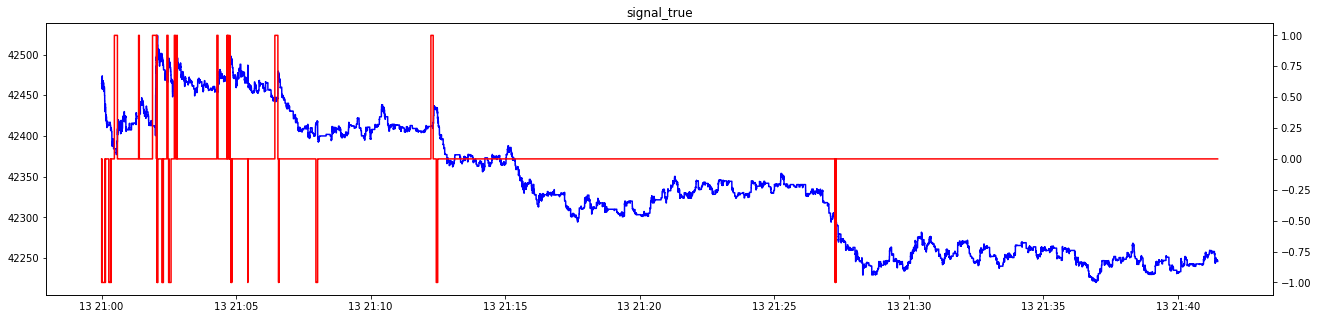

In [37]:
start, offset = 0, 40000
N0, N1 = start, start + offset

for label in 'signal_true',:

    plt.figure(figsize=(22, 5))
    plt.title(label)

    # price
    plt.step(df.index.to_series().iloc[N0:N1], (df.iloc[N0:N1]['bp0'] + df.iloc[N0:N1]['ap0'])/2, c='b')

    # label
    plt.twinx().step(df.index.to_series().iloc[N0:N1], df.iloc[N0:N1][label], c='r')

In [38]:
idxnum = range(100, len(df), 10)

# prepare model
X1 = prepare(df, idxnum, config['model']['depth'], config['model']['window_size'])

# rescale
n_samples = X1.shape[0]
X1[:] = scaler1.transform(X1[:, :, :, 0].reshape((n_samples, -1))).reshape((n_samples, config['model']['window_size'], config['model']['depth'] * 4, 1))

# encode labels
y = df['signal_true'].iloc[idxnum].to_numpy()
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y.reshape(-1, 1))

X1.shape, y.shape


((69899, 20, 40, 1), (69899, 3))

# Backtesting

In [16]:
model = build_model(window_size=config['model']['window_size'], depth=config['model']['depth'])
model.load_weights(MODEL_PATH)

In [17]:
# predict labels
ret_pred = model.predict(X1)
strategy = np.argmax(ret_pred, axis=1) - 1.

# calculating strategy
df.loc[df.index[idxnum], ['g-', 'g0', 'g+']] = ret_pred
df.loc[df.index[idxnum], 'signal_pred'] = strategy.reshape(-1)

df_strategy = df[~df.isna().any(axis=1)]

In [18]:
print(get_metrics(df_strategy['signal_true'], df_strategy['signal_pred']))

r2                    -3.56
precision            0.1981  0.9954  0.1527
recall               0.9216  0.7835  0.9233
fscore               0.3261  0.8768  0.2620
support                1493   66673    1733

confusion matrix    
   1376     112       5
   5563   52235    8875
      6     127    1600



<AxesSubplot:xlabel='timestamp'>

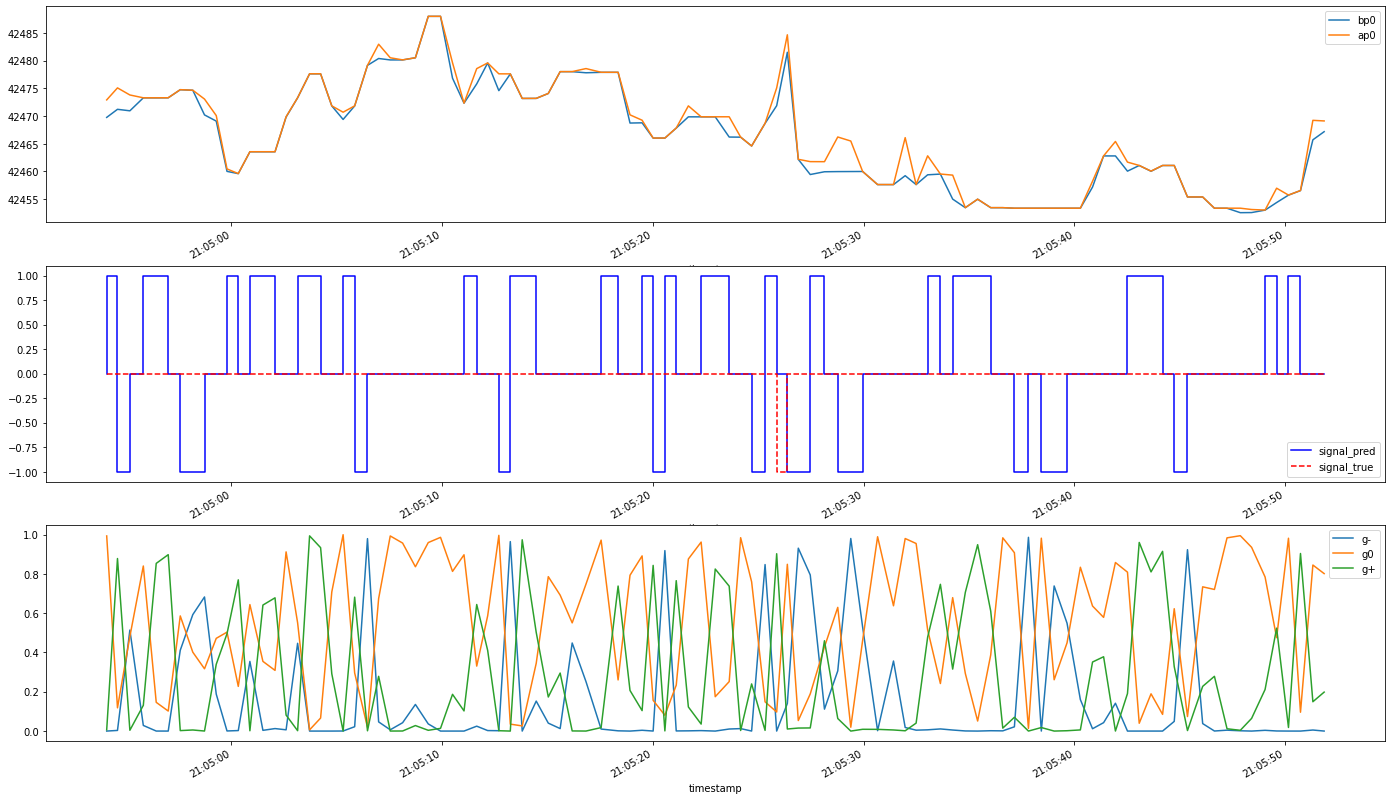

In [19]:
fig, ax = plt.subplots(nrows=3, figsize=(24, 15))

a, b = 500, 100

df_strategy[a:a+b][['bp0', 'ap0']].plot(ax=ax[0])
df_strategy[a:a+b][['signal_pred']].plot(ax=ax[1], drawstyle="steps", c='b')
df_strategy[a:a+b][['signal_true']].plot(ax=ax[1], drawstyle="steps", c='r', linestyle='dashed')
df_strategy[a:a+b][['g-', 'g0', 'g+']].plot(ax=ax[2])